In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import tensorflow.keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input

In [ ]:
data = pd.read_csv("drive/MyDrive/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
pp.ProfileReport(data)

TypeError: ignored

In [ ]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]
print(groups[0])

       emotion                                             pixels        Usage
32298        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
32299        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
32300        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
32301        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
32302        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[3589 rows x 3 columns]


In [ ]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [ ]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [ ]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

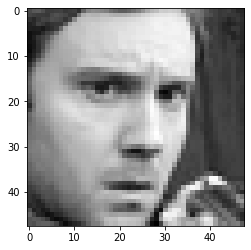

In [ ]:
plt.imshow(X_train[0][:,:,0],cmap='gray')

Text(0.5, 1.0, 'Counts per emotion in testing set')

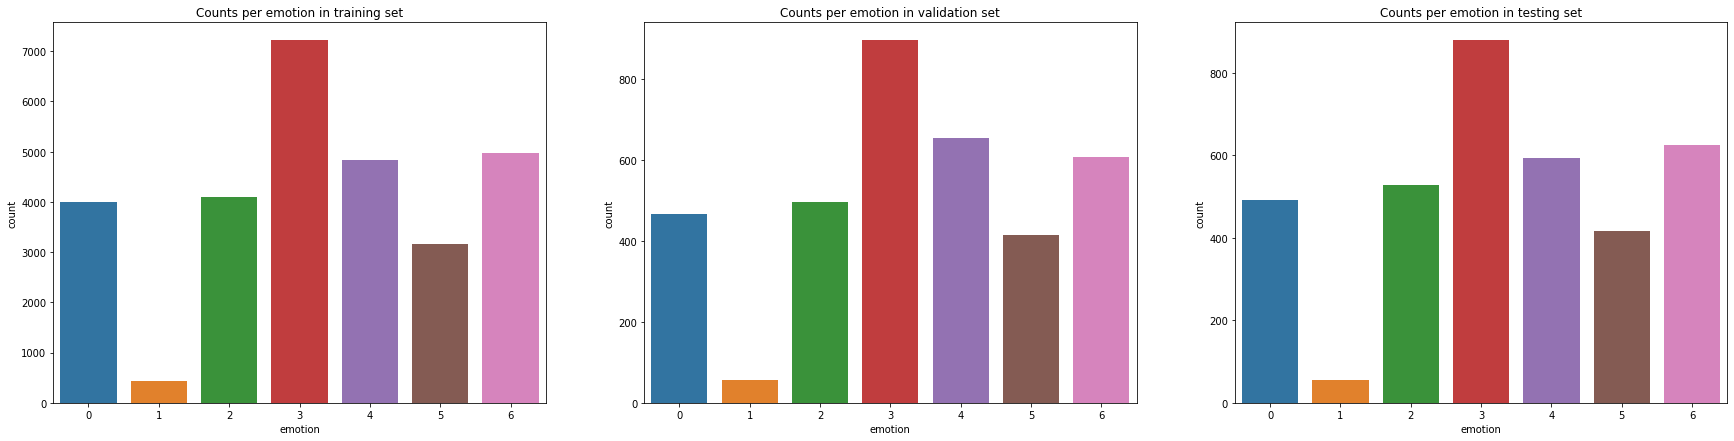

In [ ]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(x=Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(x=Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(x=Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [ ]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

AttributeError: ignored

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
optimizer = opt.Adam(learning_rate = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], epochs=50, batch_size = 100, callbacks=[lr_anneal])

Epoch 1/50
288/288 [==============================] - 21s 34ms/step - loss: 2.0090 - accuracy: 0.2530 - val_loss: 1.8392 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 2/50
288/288 [==============================] - 8s 29ms/step - loss: 1.6585 - accuracy: 0.3449 - val_loss: 1.7162 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 3/50
288/288 [==============================] - 8s 29ms/step - loss: 1.5008 - accuracy: 0.4165 - val_loss: 1.6002 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 4/50
288/288 [==============================] - 8s 29ms/step - loss: 1.3777 - accuracy: 0.4665 - val_loss: 1.5025 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 5/50
288/288 [==============================] - 8s 29ms/step - loss: 1.2993 - accuracy: 0.5002 - val_loss: 1.2794 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 6/50
288/288 [==============================] - 9s 30ms/step - loss: 1.2412 - accuracy: 0.5239 - val_loss: 1.2840 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 7/50
288/288 [==============================] - 8s 29ms/s

In [ ]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print("Test accuracy:", acc)

36/36 [==============================] - 1s 15ms/step - loss: 1.0532 - accuracy: 0.6509
Test score: 1.0531909465789795
Test accuracy: 0.6508776545524597


In [ ]:
model.save('CNN.h5')

In [ ]:
model_json = model.to_json()
with open("CNN.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("weights.h5")
print("Saved model to disk")

Saved model to disk
